# Dataset Preparation


## Data Collection


In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

seed = 1855
path = './exercises/sklearn/regression-fuel-consumption/dataset/dataset.tsv'
# the dataset does not include the header
header = ['mpg' ,'cylinders' ,'displacement' ,'horsepower' ,'weight' ,'acceleration' ,'model_year' ,'origin' ,'car_name' ]

data = pd.read_csv(path, sep='\t', names=header, na_values='?')
# Converting displacement from cubic inches to liters

data['displacement'] = data['displacement'] * 0.016387064
data.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,5.030829,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,5.735472,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,5.211086,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,4.981667,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,4.948893,140.0,3449.0,10.5,70,1,ford torino


### Plotting the Data

<Axes: title={'center': 'weight distribution'}, ylabel='Frequency'>

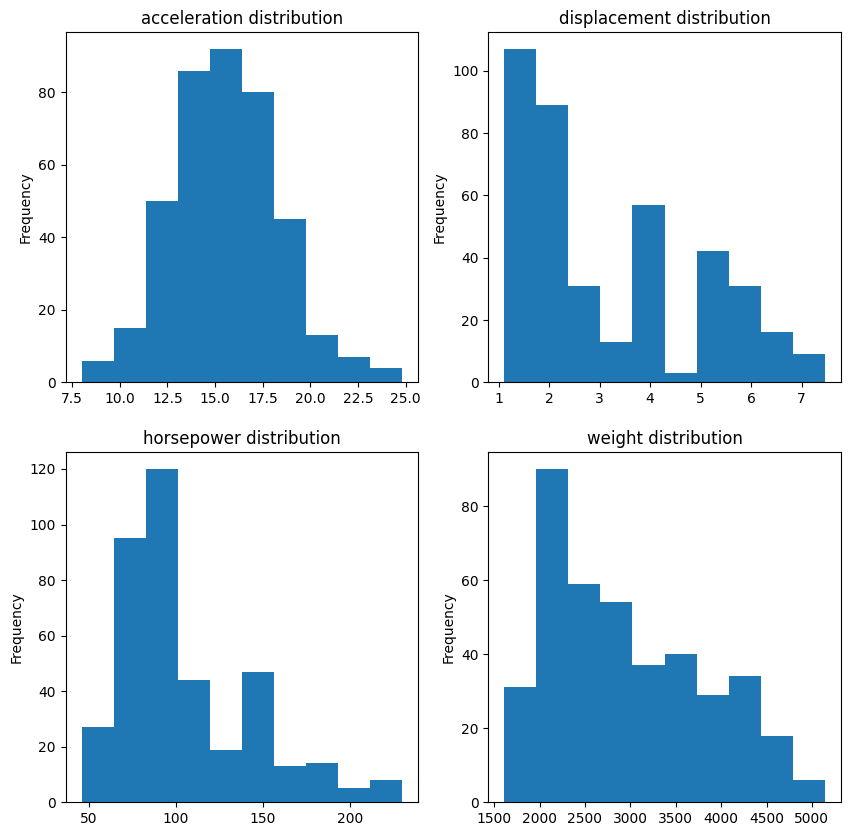

In [81]:
y_labeler = lambda x: x.set_ylabel('density')
y_labeler = np.vectorize(y_labeler)

fig, axes = plt.subplots(2,2,figsize=(10,10))
y_labeler(axes)

# Plotting the distribution of the target variable

data['acceleration'].plot(kind='hist', ax=axes[0,0], title='acceleration distribution')

# Plotting the distribution of the displacement variable

data['displacement'].plot(kind='hist', ax=axes[0,1], title='displacement distribution')

# Plotting the distribution of the horsepower variable

data['horsepower'].plot(kind='hist', ax=axes[1,0], title='horsepower distribution')

# Plotting the distribution of the weight variable

data['weight'].plot(kind='hist', ax=axes[1,1], title='weight distribution')

## Handling missing values


In [82]:
from pandas.api.types import is_numeric_dtype
print(data.isnull().sum())
data = data.apply(lambda x: x.fillna(x.mean()) if is_numeric_dtype(x) else x.fillna(x.mode().iloc[0]))
print(data.isnull().sum())


mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64


## Encoding categorical features with One-Hot Encoding


In [83]:
categorical_features = ["cylinders", "origin", "model_year"]

data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

data.head()

,mpg,displacement,horsepower,weight,acceleration,car_name,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,model_year_73,model_year_74,model_year_75,model_year_76,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82
0,18.0,5.030829,130.0,3504.0,12.0,chevrolet chevelle malibu,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,15.0,5.735472,165.0,3693.0,11.5,buick skylark 320,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,18.0,5.211086,150.0,3436.0,11.0,plymouth satellite,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,16.0,4.981667,150.0,3433.0,12.0,amc rebel sst,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,17.0,4.948893,140.0,3449.0,10.5,ford torino,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Another categorical feature in the dataset is the `car_name` column. We cannot use one-hot encoding directly on this column because it has too many unique values. Instead, we will extract the car manufacturer from the car name and use one-hot encoding on the manufacturer column.

In [84]:

def sanitize_car_name(car_name):
    s = car_name.split(' ')[0]
    mapping = {
        'chevroelt': 'chevrolet',
        'chevy': 'chevrolet',
        'maxda': 'mazda',
        'mercedes-benz': 'mercedes',
        'toyouta': 'toyota',
        'vokswagen': 'volkswagen',
        'vw': 'volkswagen'
    }
    
    if s in mapping:
        return car_name.replace(s, mapping[s])

# Correcting abbreviations in the car_name column and misspelled car names
data.apply(lambda x: sanitize_car_name(x['car_name']), axis=1)

# adding the manufacturer column
data['manufacturer'] = data['car_name'].apply(lambda x: x.split(' ')[0])


data['manufacturer'].value_counts()


manufacturer
ford             51
chevrolet        43
plymouth         31
amc              28
dodge            28
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
fiat              8
peugeot           8
audi              7
chrysler          6
vw                6
volvo             6
renault           5
saab              4
subaru            4
opel              4
chevy             3
bmw               2
cadillac          2
maxda             2
mercedes-benz     2
triumph           1
vokswagen         1
mercedes          1
hi                1
capri             1
chevroelt         1
toyouta           1
nissan            1
Name: count, dtype: int64

In [85]:
top_10_manufacturers = data['manufacturer'].value_counts().head(10).index

data['manufacturer'] = data['manufacturer'].apply(lambda x: x if x in top_10_manufacturers else 'other')

data['manufacturer'].value_counts()

data = pd.get_dummies(data, columns=['manufacturer'])

## Encoding binary class label


In [86]:
# This is a regression problem, so we don't need to encode the target variable

x = data.drop(['mpg', 'car_name'], axis=1)
y = data['mpg']

# Model Building


In [87]:
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.preprocessing import *

## Splitting the dataset into training and testing sets


In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)


std_scaler = StandardScaler().fit(x_train)
x_train_std = std_scaler.transform(x_train)
x_test_std = std_scaler.transform(x_test)

min_max_scaler = MinMaxScaler().fit(x_train)
x_train_min_max = min_max_scaler.transform(x_train)
x_test_min_max = min_max_scaler.transform(x_test)

## Evaluation function


In [89]:
def evaluate(expected, predicted):
    print(f'Mean Absolute Error: {mean_absolute_error(expected, predicted)}')
    print(f'Mean Squared Error: {mean_squared_error(expected, predicted)}')
    print(f'R2 Score: {r2_score(expected, predicted)}')
    
def plot(expected, predicted, title = 'Results'):
  fig, ax = plt.subplots()
  ax.scatter(expected, predicted, edgecolors=(0, 0, 0), color='red')
  ax.plot([expected.min(), expected.max()], [expected.min(), expected.max()], 'k--', lw=4)
  ax.set_xlabel('Expected')
  ax.set_ylabel('Predicted')
  ax.set_title(title)
  

## Model Building


In [90]:
model = LinearRegression().fit(x_train_std, y_train)

## Model Evaluation


Mean Absolute Error: 2.3470560653564907
Mean Squared Error: 8.737425446610171
R2 Score: 0.8273866694195772


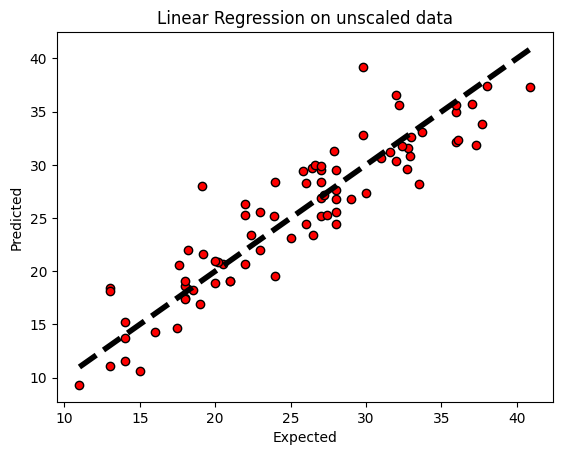

In [91]:
model.fit( x_train, y_train)
mpg_pred = model.predict(x_test)
evaluate(y_test, mpg_pred)
plot(y_test, mpg_pred, title = 'Linear Regression on unscaled data')

Mean Absolute Error: 2.347056065356438
Mean Squared Error: 8.737425446610152
R2 Score: 0.8273866694195775


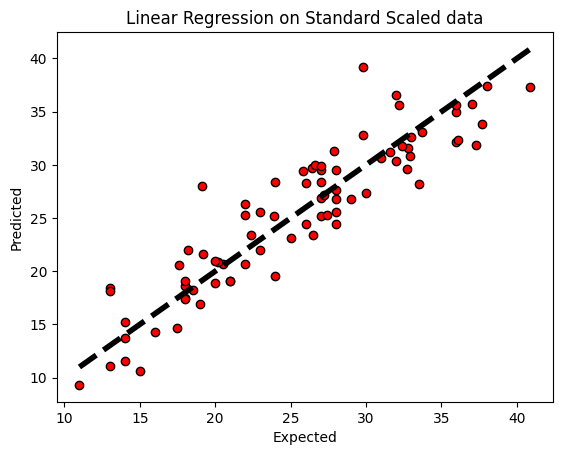

In [92]:
model = LinearRegression()
model.fit( x_train_std, y_train)
mpg_pred = model.predict(x_test_std)
evaluate(y_test, mpg_pred)
plot(y_test, mpg_pred, title = 'Linear Regression on Standard Scaled data')

Mean Absolute Error: 2.347056065356436
Mean Squared Error: 8.737425446610153
R2 Score: 0.8273866694195775


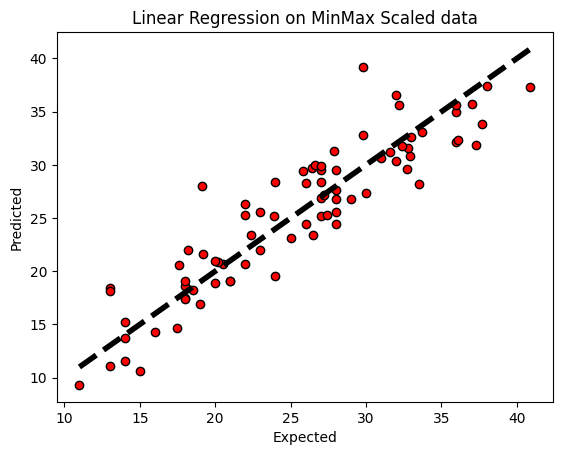

In [93]:
model = LinearRegression()
model.fit( x_train_min_max, y_train)
mpg_pred = model.predict(x_test_min_max)
evaluate(y_test, mpg_pred)
plot(y_test, mpg_pred, title = 'Linear Regression on MinMax Scaled data')

In [101]:
cv_model = LinearRegression()
cross_validation_scores = cross_val_score(cv_model, x_train, y_train, cv=10, scoring='r2')
print(f"***** Cross Validation summary *****")
for v in range(0, len(cross_validation_scores)):
  print(f"R2 score on fold-{v+1} = {cross_validation_scores[v]:.3f}")
print(f"Mean R2 score = {cross_validation_scores.mean():.3f} +/- {cross_validation_scores.std():.3f}")


***** Cross Validation summary *****
R2 score on fold-1 = 0.835
R2 score on fold-2 = 0.844
R2 score on fold-3 = 0.881
R2 score on fold-4 = 0.899
R2 score on fold-5 = 0.885
R2 score on fold-6 = 0.823
R2 score on fold-7 = 0.821
R2 score on fold-8 = 0.867
R2 score on fold-9 = 0.865
R2 score on fold-10 = 0.824
Mean R2 score = 0.854 +/- 0.027


In [103]:
cv_model = LinearRegression()
k_fold = KFold(n_splits=10, random_state=seed, shuffle=True)
cross_validation_scores = cross_val_score(cv_model, x_train, y_train, cv=k_fold, scoring='r2')
print(f"***** Cross Validation (K-Fold) summary *****")
for v in range(0, len(cross_validation_scores)):
  print(f"R2 score on fold-{v+1} = {cross_validation_scores[v]:.3f}")
print(f"Mean R2 score = {cross_validation_scores.mean():.3f} +/- {cross_validation_scores.std():.3f}")


***** Cross Validation (K-Fold) summary *****
R2 score on fold-1 = 0.798
R2 score on fold-2 = 0.868
R2 score on fold-3 = 0.903
R2 score on fold-4 = 0.811
R2 score on fold-5 = 0.807
R2 score on fold-6 = 0.871
R2 score on fold-7 = 0.791
R2 score on fold-8 = 0.839
R2 score on fold-9 = 0.823
R2 score on fold-10 = 0.889
Mean R2 score = 0.840 +/- 0.038


## Model Building with Hyperparameter Tuning



## Model Evaluation


# Comparing Different Models Performance